# infos

In [1]:
# Charger le modèle. Chaque chapitre qui suivra est indépendant des autres


# Vérifier que les chemins soient correct avant toutes opérations
chemin_images = '../../images/'

# Dimensions des images
img_size = (224,224,3)

Reste à faire :
- Comprendre les fonctions définies dans Grad Cam (il s'agit d'un copier/coller)
- 

# Librairies à charger

In [3]:
# Librairies servant à charger le modèle
from tensorflow import keras


# Librairies servant à l'interprétabilité du modèle
from IPython.display import Image, display
import matplotlib.cm as cm
%matplotlib inline

# Chargement du modèle

In [ ]:
nom_model = '../model/gpot_v01_echantillon'
model = keras.models.load_model(nom_modele)

## Interprétabilité (Grad Cam)

### fonctions pour Grad Cam

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 292249, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### Grad Cam

In [5]:
# Définir l'image servant à tester l'interprétabilité
img_path = '../../images/28.jpg'

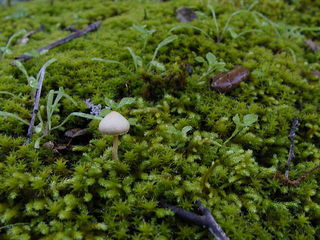

In [6]:
model_builder = keras.applications.xception.Xception
img_size = img_dim
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"


display(Image(img_path))

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
grad = model_builder(weights="imagenet")

# Remove last layer's softmax
grad.layers[-1].activation = None

# Print what the top predicted class is
preds = grad.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
save_and_display_gradcam(img_path, heatmap)